# 1. Import Library

In [1]:
#!pip uninstall graphviz
#pip install graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Diode/Anaconda3/envs/TF2_GPU/Library/bin/graphviz/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Graph

import random


Bad key "text.kerning_factor" on line 4 in
C:\Users\Diode\Anaconda3\envs\TF2_GPU\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
np.random.choice(5, 5) # np.arange(5) , size 3:

array([1, 1, 2, 3, 2])

In [4]:
range(5)

range(0, 5)

In [5]:

print(random.sample(range(5),3))

[4, 2, 1]


# 2. Write Function

### Decision Tree

In [6]:
def DT_find_best_question(X, Y, Feature_Name, Feature_Index, All_Class):
    max_Gain = -np.inf
    isComplete = False
    Gini_Parent = DT_compute_Gini(Y, All_Class)
    Question_Dict = DT_create_Question(X, Feature_Name)
    for d, fn in enumerate(Feature_Name):
        N = X.shape[0]
        if fn in Question_Dict:
            unique_value = Question_Dict[fn]['unique_value']
            check_type = Question_Dict[fn]['type_of_feature']
            for i, uv in enumerate(unique_value):                
                filter_true, filter_false = DT_find_filter(X, check_type, d, uv)
                X_True = X[filter_true]; Y_True = Y[filter_true];
                X_False = X[filter_false]; Y_False = Y[filter_false];
                weight_true, weight_false = DT_compute_weight_true_false(filter_true, filter_false, N)
                Gini_True, Gini_False = DT_compute_Gini_True_False(Y_True, Y_False, All_Class)
                Gini_Children = DT_compute_Gini_Children(weight_true, Gini_True, weight_false, Gini_False)
                Gain = DT_compute_Gain(Gini_Parent, Gini_Children)
                if Gain >= max_Gain:
                    max_Gain = Gain
                    best = {}
                    best['fn'] = fn
                    best['findex'] = Feature_Index[d]  ## เพิ่มตรงนี้มาโดยเฉพาะ (คำำถามที่ดีสุดอยู่ Index ไหน)
                    best['uv'] = uv
                    best['X_True'] = X_True
                    best['Y_True'] = Y_True
                    best['X_False'] = X_False
                    best['Y_False'] = Y_False
                if max_Gain == Gini_Parent:
                    isComplete = True
                    return best, isComplete
    return best, isComplete

In [7]:
def DT_create_Question(X, Feature_Name):
    Question_Dict = {}
    for d, fn in enumerate(Feature_Name):
        unique_value = np.unique(X[:, d])
        check_type = type(unique_value[0])
        if check_type == str:
            if len(unique_value) >= 2:
                if len(unique_value) == 2:
                    unique_value = unique_value[:1]
                q = {}
                q['type_of_feature'] = 'discrete'
                q['unique_value'] = unique_value
                Question_Dict[fn] = q
        if (check_type == int) or (check_type == float):
            unique_value = unique_value[1:-1]
            if len(unique_value) != 0:            
                q = {}
                q['type_of_feature'] = 'continuous'
                q['unique_value'] = unique_value
                Question_Dict[fn] = q
    return Question_Dict

In [8]:
def DT_compute_Gini(Y, All_Class):
    n_class = len(All_Class)
    N = Y.shape[0]
    if N == 0:
        Gini = 0
    elif N != 0 :
        p = np.zeros([1, n_class])
        for c, _class in enumerate(All_Class):
            p[0, c] = (Y == _class).sum()/N
        Gini = 1 - (p**2).sum()
    return Gini

In [9]:
def DT_find_filter(X, check_type, d, uv):
    if check_type == 'discrete':
        filter_true = np.argwhere(X[:, d] == uv).ravel()
        filter_false = np.argwhere(X[:, d] != uv).ravel()
    elif check_type == 'continuous':
        filter_true = np.argwhere(X[:, d] >= uv).ravel()
        filter_false = np.argwhere(X[:, d] < uv).ravel()
    return filter_true, filter_false

In [10]:
def DT_compute_weight_true_false(filter_true, filter_false, N):
    count_true = len(filter_true)
    count_false = N - count_true
    weight_true = count_true/N
    weight_false = count_false/N
    return weight_true, weight_false

In [11]:
def DT_compute_Gini_True_False(Y_True, Y_False, All_Class):
    Gini_True = DT_compute_Gini(Y_True, All_Class)
    Gini_False = DT_compute_Gini(Y_False, All_Class)
    return Gini_True, Gini_False

In [12]:
def DT_compute_Gini_Children(weight_true, Gini_True, weight_false, Gini_False):
    Gini_Children = weight_true*Gini_True + weight_false*Gini_False
    return Gini_Children

In [13]:
def DT_compute_Gain(Gini_Parent, Gini_Children):
    Gain = Gini_Parent - Gini_Children
    return Gain

In [14]:
def DT_grow_tree(best, Y_True, Y_False, All_Class):
    fn = best['fn']
    findex = best['findex']
    uv = best['uv']
    if type(uv) == str:
        type_of_feature = 'discrete'
    elif (type(uv) == float) or (type(uv) == int):
        type_of_feature = 'continuous'
    
    Question = {} 
    Question['fn'] = fn
    Question['findex'] = findex; Question['uv'] = uv
    Question['type_of_feature'] = type_of_feature
    
    Leaf_Node_True, Vote_True, Max_Vote_True, Max_Class_True = DT_Leaf(Y_True, All_Class)
    True_Branch = {}
    True_Branch['Leaf_Node'] = Leaf_Node_True
    True_Branch['Vote'] = Vote_True
    True_Branch['Predict'] = Max_Class_True
    True_Branch['Percent'] = Max_Vote_True
    
    Leaf_Node_False, Vote_False, Max_Vote_False, Max_Class_False = DT_Leaf(Y_False, All_Class)
    False_Branch = {} 
    False_Branch['Leaf_Node'] = Leaf_Node_False
    False_Branch['Vote'] = Vote_False
    False_Branch['Predict'] = Max_Class_False
    False_Branch['Percent'] = Max_Vote_False
    
    Decision_Node = {}
    Decision_Node['Question'] = Question
    Decision_Node['True_Branch'] = True_Branch
    Decision_Node['False_Branch'] = False_Branch
    
    return Decision_Node, Max_Vote_True, Max_Vote_False

In [15]:
def DT_Leaf(Y, All_Class):
    N = Y.shape[0]
    leaf_node = {}
    vote = {}
    max_vote = -np.inf
    for c, _class in enumerate(All_Class):
        length = (Y == _class).sum()
        percent_vote = 100*length/N
        if max_vote < percent_vote:
            max_vote = percent_vote
            max_class = _class
        leaf_node[_class] = length
        vote[_class] = percent_vote
    return leaf_node, vote, max_vote, max_class

In [16]:
def DT_fit(X_Train, Y_Train, Feature_Name, Feature_Index, All_Class, max_depth=np.inf, depth=1, max_majority=np.inf, min_leaf=-np.inf):
    best, isComplete = DT_find_best_question(X_Train, Y_Train, Feature_Name, Feature_Index, All_Class)
    Y_True = best['Y_True']
    Y_False = best['Y_False']
    Decision_Node, Max_Vote_True, Max_Vote_False = DT_grow_tree(best, Y_True, Y_False, All_Class)

    if max_depth == depth:
        return Decision_Node
    if isComplete == True:
        return Decision_Node
    
    if Max_Vote_True < max_majority:
        if len(Y_True) > min_leaf:
            X_True = best['X_True']
            Decision_Node['True_Branch']['Decision_Node']  = DT_fit(X_True, Y_True, Feature_Name, Feature_Index, All_Class, max_depth=max_depth, depth=depth+1, max_majority=max_majority, min_leaf=min_leaf)
    if Max_Vote_False < max_majority:
        if len(Y_False) > min_leaf:
            X_False = best['X_False']
            Decision_Node['False_Branch']['Decision_Node'] = DT_fit(X_False ,Y_False, Feature_Name, Feature_Index, All_Class, max_depth=max_depth, depth=depth+1, max_majority=max_majority, min_leaf=min_leaf)
    return Decision_Node

In [17]:
def DT_recursive_predict(x_test, tree):
    fn = tree['Question']['fn']
    findex = tree['Question']['findex']
    value = tree['Question']['uv']
    type_of_feature = tree['Question']['type_of_feature']

    if type_of_feature == 'discrete':
        if x_test[findex] == value:
            if 'Decision_Node' not in tree['True_Branch']:
                predict = tree['True_Branch']['Predict']
                percent = tree['True_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['True_Branch']:
                tree = tree['True_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat
        elif x_test[findex] != value:
            if 'Decision_Node' not in tree['False_Branch']:
                predict = tree['False_Branch']['Predict']
                percent = tree['False_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['False_Branch']:
                tree = tree['False_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat
                
    if type_of_feature == 'continuous':
        if x_test[findex] >= value:
            if 'Decision_Node' not in tree['True_Branch']:
                predict = tree['True_Branch']['Predict']
                percent = tree['True_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['True_Branch']:
                tree = tree['True_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat
        elif x_test[findex] < value:
            if 'Decision_Node' not in tree['False_Branch']:
                predict = tree['False_Branch']['Predict']
                percent = tree['False_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['False_Branch']:
                tree = tree['False_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat

In [18]:
def DT_predict(X_Test, tree):
    Yhat = []
    for x_test in X_Test:
        yhat = DT_recursive_predict(x_test, tree)
        Yhat.append(yhat)
    return np.array(Yhat)

In [19]:
def find_error_classification(Y, Yhat):
    N = Y.shape[0]
    error = (100/N)*(Y != Yhat).sum()
    return error

In [20]:
def DT_print_tree(node, prev_id, spacing=""):
    global curr_id  
    curr_id += 1
    
    if 'Question' not in node:
        node_predictions = "{} : {}".format(node['Predict'], round(node['Percent'], 2))
        g.node(str(prev_id), label=str(node_predictions))
        return
    
    node_question = "{} {} {}".format(node['Question']['fn'], '=' if isinstance(node['Question']['uv'], str) else '>=', node['Question']['uv'] if isinstance(node['Question']['uv'], str) else round(node['Question']['uv'], 6))
    g.node(str(prev_id), label=str(node_question))

    true_node = node['True_Branch']['Decision_Node'] if 'Decision_Node' in node['True_Branch'] else node['True_Branch']
    V.append((prev_id, curr_id))
    DT_print_tree(true_node, curr_id, spacing + "  ")
    
    false_node = node['False_Branch']['Decision_Node'] if 'Decision_Node' in node['False_Branch'] else node['False_Branch']
    V.append((prev_id, curr_id))
    DT_print_tree(false_node, curr_id, spacing + "  ")

### Random Forest

In [21]:
def RF_fit(X_Train, Y_Train, Feature_Name, All_Class, n_tree=10, boostrap=True, max_depth=np.inf, depth=1, max_majority=np.inf, min_leaf=-np.inf):
    N, D = X_Train.shape
    if boostrap == True:
        example_index = np.random.choice(N, N)
        X_Train = X_Train[example_index]
        Y_Train = Y_Train[example_index]
    forest = []
    for i in range(n_tree):
        n_filter_feature = int(np.sqrt(D))
        feature_index = random.sample(range(D), n_filter_feature)
        Feature_to_forest = Feature_Name[feature_index]
        X_to_forest = X_Train[:, feature_index]
        tree = DT_fit(X_to_forest, Y_Train, Feature_to_forest, feature_index, All_Class, max_depth=max_depth, max_majority=max_majority, min_leaf=min_leaf)
        forest.append(tree)
    return forest

In [22]:
def RF_predict(X_Test, forest):
    N = X_Test.shape[0]
    n_tree = len(forest)
    Yhat_forest = np.empty([N, 0])
    for i in range(n_tree):
        tree = forest[i]
        Yhat_each_tree = DT_predict(X_Test, tree)[:, 0:1]
        Yhat_forest = np.hstack([Yhat_forest, Yhat_each_tree])
    Yhat_Test = []
    for Y in Yhat_forest:
        unique_prediction, count_unique_prediction = np.unique(Y, return_counts=True)
        prediction = unique_prediction[count_unique_prediction.argmax()]
        percent = count_unique_prediction.max()/n_tree
        yhat_test = np.array([prediction, percent])
        Yhat_Test.append(yhat_test)
    return np.array(Yhat_Test)

# 3. Read Data & Prepare Data

In [23]:
Data = pd.read_excel('BMI_Dataset_Classification.xlsx', usecols = 'A:C')

In [24]:
Data

,Weight,Height,Target
0,66.17,185.21,normal
1,71.27,168.91,fat lv3
2,73.17,179.83,normal
3,81.74,171.76,fat lv2
4,92.97,172.89,fat lv3
...,...,...,...
995,63.24,141.45,fat lv3
996,47.55,166.64,thin
997,68.10,168.52,fat lv1
998,74.39,169.24,fat lv2


In [25]:
DataMatrix = Data.values

In [26]:
DataMatrix = np.array(DataMatrix, dtype='object')

In [27]:
DataMatrix.shape

(1000, 3)

In [28]:
D = DataMatrix.shape[1] - 1

In [29]:
X = DataMatrix[:, :D]
Y = DataMatrix[:, D:]

In [30]:
start_train = -900
end_train = -150
# end_test = -150

In [31]:
X_Train = X[start_train:end_train, :]
Y_Train = Y[start_train:end_train, :]

X_Test = X[end_train:, :]
Y_Test = Y[end_train:, :]

# X_Test = X[end_train:end_test, :]
# Y_Test = Y[end_train:end_test, :]

# 4. Create Model

In [32]:
Feature_Name = np.array(Data.columns[:-1])
All_Class, Count_All_Class = np.unique(Y_Train[:, :], return_counts = True)

In [33]:
forest = RF_fit(X_Train, Y_Train, Feature_Name, All_Class, max_depth = 5, max_majority = 65, min_leaf = 20)

In [34]:
print(type(forest))
print(len(forest))

<class 'list'>
10


In [35]:
forest

[{'Question': {'fn': 'Height',
   'findex': 1,
   'uv': 168.07,
   'type_of_feature': 'continuous'},
  'True_Branch': {'Leaf_Node': {'fat lv1': 99,
    'fat lv2': 70,
    'fat lv3': 42,
    'normal': 181,
    'thin': 60},
   'Vote': {'fat lv1': 21.902654867256636,
    'fat lv2': 15.486725663716815,
    'fat lv3': 9.29203539823009,
    'normal': 40.04424778761062,
    'thin': 13.274336283185841},
   'Predict': 'normal',
   'Percent': 40.04424778761062,
   'Decision_Node': {'Question': {'fn': 'Height',
     'findex': 1,
     'uv': 174.13,
     'type_of_feature': 'continuous'},
    'True_Branch': {'Leaf_Node': {'fat lv1': 39,
      'fat lv2': 12,
      'fat lv3': 19,
      'normal': 111,
      'thin': 32},
     'Vote': {'fat lv1': 18.309859154929576,
      'fat lv2': 5.633802816901408,
      'fat lv3': 8.92018779342723,
      'normal': 52.11267605633803,
      'thin': 15.023474178403756},
     'Predict': 'normal',
     'Percent': 52.11267605633803,
     'Decision_Node': {'Question': {'fn'

# 2.5 วาดต้นไม้

In [36]:
def DT_print_tree(node, prev_id, spacing=""):
    global curr_id  
    curr_id += 1
    
    if 'Question' not in node:
        node_predictions = "{} : {}".format(node['Predict'], round(node['Percent'], 2))
        g.node(str(prev_id), label=str(node_predictions))
        return
    
    node_question = "{} {} {}".format(node['Question']['fn'], '=' if isinstance(node['Question']['uv'], str) else '>=', node['Question']['uv'] if isinstance(node['Question']['uv'], str) else round(node['Question']['uv'], 6))
    g.node(str(prev_id), label=str(node_question))

    true_node = node['True_Branch']['Decision_Node'] if 'Decision_Node' in node['True_Branch'] else node['True_Branch']
    V.append((prev_id, curr_id))
    DT_print_tree(true_node, curr_id, spacing + "  ")
    
    false_node = node['False_Branch']['Decision_Node'] if 'Decision_Node' in node['False_Branch'] else node['False_Branch']
    V.append((prev_id, curr_id))
    DT_print_tree(false_node, curr_id, spacing + "  ")

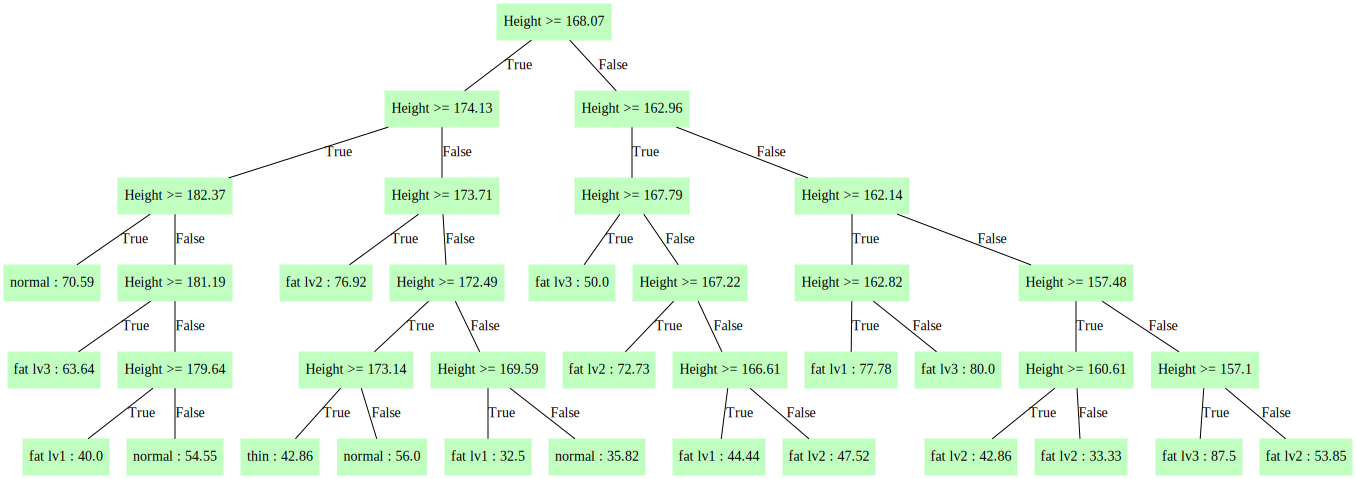

In [37]:
g = Graph('G')
g.attr('node', shape='box', style='filled', color='darkseagreen1')
curr_id = 1   
V = []
DT_print_tree(forest[0], curr_id)

for v in V:
    g.edge(str(v[0]), str(v[1]), 'True' if v[1] - v[0] == 1 else 'False')
g

# 5. Making Prediction

In [38]:
Yhat_Test = RF_predict(X_Test, forest)

In [39]:
error_Test = find_error_classification(Y_Test, Yhat_Test[:, 0:1])

In [40]:
error_Test

54.666666666666664